# Машинное обучение
## Лабораторная работа №2

Выполнил студент группы 15-В-2   
Соболев Д. А.   
Вариант №12

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import auc, roc_curve, precision_recall_curve

D:\progs\WinPython\python-3.6.2.amd64\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\progs\WinPython\python-3.6.2.amd64\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv(r'data/titanic3.csv', sep=';')
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29,0.0,0.0,24160,"211,3375",B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,"0,9167",1.0,2.0,113781,"151,5500",C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1.0,2.0,113781,"151,5500",C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
df.shape

(1310, 14)

In [4]:
df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

### 1) Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных

| Переменная   | Описание  | Параметры(Ключи)  | 
|--------------|--------------|-------------------|
|pclass        |класс билета  |1 - 1 класс; 2 -  2 класс; 3 -  3 класс |
|survived| выживание| 0 - Нет ;1 - Да|
|name|имя|любой|
|sex|пол|female - женский, male - мужской|
|age|возраст|любой числовой|
|sibsp|число братьев, сестер, супругов на борту|любой числовой|
|parch|число родителей, детей на ботру|любой числовой|
|fare|цена билета(британский фунт)|любой числовой|
|ticket|номер билета|любой|
|cabin|номер каюты|любой|
|embarked|порт погрузки|C = Cherbourg, Q = Queenstown, S = Southampton|
|boat|номер спасательной шлюпки|любой|
|body|идентификационный номер тела|любой|
|home.dest|Дом/Назначение|любой|    

**Задача: по данным признакам предсказать, выживет ли пасажир.**     

При решении задачи некоторые признаки будут лишними. К ним можно отнести:
 - body, так как по его наличию id тела однозначно видно, что человек умер, а само значение ни о чем не говорит;    
 - boat, тоже самое можно сказать про номер шлюпки - если он есть, то человек спасен;     
 - ticket, так как номер билета ни о чем не говорит;      
 - cabin, мог бы пригодиться: возможно и есть зависимость между и номером кабины и ее расположением на корабле, которое благоприятно для выживания человека. Но это поле слабо заполнено, и восстановить его правильно не получится.
 - home.dst, также слишком слабо заполнено
 - name, имя точно не влияет на спасение человка, имен огромное множество, и среди них искать закономерности - не наша задача

In [5]:
list_to_drop = ['body', 'boat', 'name', 'cabin', 'ticket', 'home.dest']
df.drop(list_to_drop, axis=1, inplace=True)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,29,0.0,0.0,"211,3375",S
1,1.0,1.0,male,"0,9167",1.0,2.0,"151,5500",S
2,1.0,0.0,female,2,1.0,2.0,"151,5500",S
3,1.0,0.0,male,30,1.0,2.0,"151,5500",S
4,1.0,0.0,female,25,1.0,2.0,"151,5500",S


In [6]:
df.count()

pclass      1309
survived    1309
sex         1309
age         1046
sibsp       1309
parch       1309
fare        1308
embarked    1307
dtype: int64

### 2) Удалите дубликаты строк в наборе данных

In [7]:
df = df.drop_duplicates()
df.shape

(1115, 8)

In [8]:
df.count()

pclass      1114
survived    1114
sex         1114
age          974
sibsp       1114
parch       1114
fare        1113
embarked    1112
dtype: int64

### 3) Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

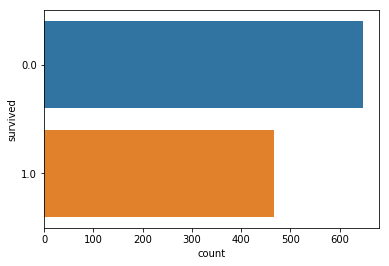

In [9]:
sns.countplot(data=df, y='survived')
plt.show()

Соотношение количество элементов заметно отличается, поэтому будем считать, что классы несбалансированы.    
Будем использовать ROC-кривую, поскольку она дает адекватную оценку качества работы алгоритма, где классы несбалансированы и их размеры выборки отличаются друг от друга несущественно (не на порядок)

### 4)  Выполните масштабирование количественных признаков

In [10]:
# выделим категориальные и числовые(количественные) признаки
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)


numerical:  ['pclass', 'survived', 'sibsp', 'parch']
categorial:  ['sex', 'age', 'fare', 'embarked']


age и fare по форме должны быть числовыми, но из-за разделителя дробной части ввиде запятой, питон видит их как строки. Преобразуем их к числовому виду

In [11]:
def cast(obj):
    if type(obj) == str:
        return float(obj.replace(',', '.'))
    else:
        return obj

df['age'] = df['age'].apply(lambda x: cast(x))
df['fare'] = df['fare'].apply(lambda x: cast(x))



pclass должен относиться к категориальным признакам, а не количественным (не должно быть так, чтобы 1-ый и 2-ой классы в сумме давали 3-ий, или нечто подобное)

In [12]:
df['pclass'] = df['pclass'].apply(lambda x: str(x))

#заново выделим категориальные и числовые
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['survived', 'age', 'sibsp', 'parch', 'fare']
categorial:  ['pclass', 'sex', 'embarked']


sklearn не работает с пустыми значениями, поэтому заполним/выбросим их

In [13]:
# заполним пропущенные значения параметра age медианными,
# чтобы не потерять много данных при очистке строк с пустыми полями
df['age'] = df['age'].fillna(df['age'].median())
df = df.dropna().reset_index(drop=True)
df.count()

pclass      1111
survived    1111
sex         1111
age         1111
sibsp       1111
parch       1111
fare        1111
embarked    1111
dtype: int64

In [14]:
# нормализуем
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,0.361169,0.000,0.000000,0.412503,S
1,1.0,1.0,male,0.009395,0.125,0.222222,0.295806,S
2,1.0,0.0,female,0.022964,0.125,0.222222,0.295806,S
3,1.0,0.0,male,0.373695,0.125,0.222222,0.295806,S
4,1.0,0.0,female,0.311064,0.125,0.222222,0.295806,S


### 5) Выполните замену категориальных признаков

In [15]:
# выведем уникальные значения 
for i in categorial_columns:
    print(i,': ', df[i].unique())

pclass :  ['1.0' '2.0' '3.0']
sex :  ['female' 'male']
embarked :  ['S' 'C' 'Q']


In [16]:
# выделим бинарные и небинарные признаки
binary_columns = [i for i in categorial_columns if len(df[i].unique()) == 2]
nonbinary_columns = [i for i in categorial_columns if len(df[i].unique()) > 2]

# для бинарных заменим значения на 1 и 0
for col in binary_columns:
    for i, unic_item in enumerate(df[col].unique()):
        df[col] = df[col].replace(to_replace=[unic_item], value=[i])
        
# для не бинарых применим dummy-кодирование
df_nonbinary = pd.get_dummies(df[nonbinary_columns])
df.drop(nonbinary_columns, axis=1, inplace=True)
df = pd.concat([df_nonbinary, df] , axis=1)

print(df.shape)
df.head()

(1111, 12)


,pclass_1.0,pclass_2.0,pclass_3.0,embarked_C,embarked_Q,embarked_S,survived,sex,age,sibsp,parch,fare
0,1,0,0,0,0,1,1.0,0,0.361169,0.000,0.000000,0.412503
1,1,0,0,0,0,1,1.0,1,0.009395,0.125,0.222222,0.295806
2,1,0,0,0,0,1,0.0,0,0.022964,0.125,0.222222,0.295806
3,1,0,0,0,0,1,0.0,1,0.373695,0.125,0.222222,0.295806
4,1,0,0,0,0,1,0.0,0,0.311064,0.125,0.222222,0.295806


### 6) Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

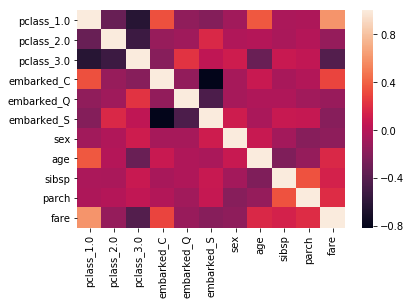

In [17]:
df_corr = df.drop('survived', axis=1).corr()
sns.heatmap(df_corr)
plt.show()

In [18]:
df_corr

,pclass_1.0,pclass_2.0,pclass_3.0,embarked_C,embarked_Q,embarked_S,sex,age,sibsp,parch,fare
pclass_1.0,1.000000,-0.328892,-0.627709,0.334279,-0.159778,-0.208995,-0.085627,0.366644,-0.042350,-0.038106,0.596881
pclass_2.0,-0.328892,1.000000,-0.528693,-0.132455,-0.096509,0.176612,-0.027632,-0.008998,-0.049192,-0.010906,-0.139155
pclass_3.0,-0.627709,-0.528693,1.000000,-0.191272,0.223164,0.042266,0.099741,-0.322128,0.078614,0.043240,-0.421780
embarked_C,0.334279,-0.132455,-0.191272,1.000000,-0.155036,-0.814749,-0.069667,0.079976,-0.060418,-0.019729,0.294691
embarked_Q,-0.159778,-0.096509,0.223164,-0.155036,1.000000,-0.446488,-0.065294,-0.029736,-0.031391,-0.087189,-0.120226
embarked_S,-0.208995,0.176612,0.042266,-0.814749,-0.446488,1.000000,0.101422,-0.054985,0.073147,0.069042,-0.196352
sex,-0.085627,-0.027632,0.099741,-0.069667,-0.065294,0.101422,1.000000,0.071614,-0.079152,-0.195243,-0.166315
age,0.366644,-0.008998,-0.322128,0.079976,-0.029736,-0.054985,0.071614,1.000000,-0.227817,-0.136196,0.172287
sibsp,-0.042350,-0.049192,0.078614,-0.060418,-0.031391,0.073147,-0.079152,-0.227817,1.000000,0.342894,0.137128
parch,-0.038106,-0.010906,0.043240,-0.019729,-0.087189,0.069042,-0.195243,-0.136196,0.342894,1.000000,0.196667


Видна сильная отрицательная зависимость между параметрами, которые были выделены dummy-кодированием, что естественно. Слабая зависимость между parch и sibsp, что тоже нормально. Средняя зависимость между fate(цена билета) и уровнем класса говорит, что параметры близки друг другу, и есть избыточные данные.

### 7)   Заполните пропущенные значения в данных

In [19]:
df.shape

(1111, 12)

In [20]:
df.count()

pclass_1.0    1111
pclass_2.0    1111
pclass_3.0    1111
embarked_C    1111
embarked_Q    1111
embarked_S    1111
survived      1111
sex           1111
age           1111
sibsp         1111
parch         1111
fare          1111
dtype: int64

### 8)	Решите поставленную задачу классификации в соответствии с заданием

- классификатор K ближайших соседей (задаётся радиус для выбора ближайших объектов)
- логический классификатор (бинарное решающее дерево)

In [21]:
# разделим полученные данные на данные для обучения и теста
X, y = df.drop('survived', axis=1), df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print(X_train.shape)
print(X_test.shape)

(777, 11)
(334, 11)


In [22]:
rnc = RadiusNeighborsClassifier(outlier_label=1)

radius_array = np.arange(0, 5, 0.25)

grid = GridSearchCV(rnc, param_grid={'radius': radius_array})
grid.fit(X_train, y_train)

best_err = 1 - grid.best_score_
best_radius = grid.best_estimator_.radius
print('best train error:', best_err, '\t at radius:', best_radius)

rnc = RadiusNeighborsClassifier(radius=best_radius, outlier_label=1)
rnc.fit(X_train, y_train)
err_test  = np.mean(y_test  != rnc.predict(X_test))
print('test error: ', err_test)

best train error: 0.2213642213642214 	 at radius: 0.5
test error:  0.224550898204
